In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import time


cuda = True

In [2]:
train = np.load("./data/loc_train_springs5.npy")

print(train.shape)
print(train[0][:][0][1].shape)

(1000, 49, 2, 5)
(5,)


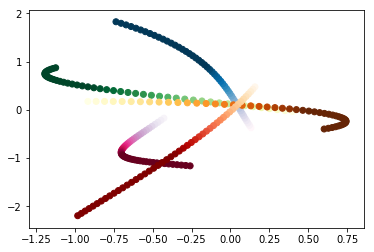

In [3]:
data = train[10]
data = np.transpose(data)
maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]
for part in range(5):
    cmap = maps[part](10*np.arange(49))
    plt.scatter(*data[part], c=cmap)

In [4]:
from utils import *
from modules import *

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    128, "_springs5")

In [5]:
def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    encoder.train()
    decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)

        optimizer.zero_grad()

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
        prob = my_softmax(logits, -1)

        if DECODER_TYPE == 'rnn':
            output = decoder(data, edges, rel_rec, rel_send, 100,
                             burn_in=True,
                             burn_in_steps=NUM_TIMESTEPS - PREDICTION_STEPS)
        else:
            output = decoder(data, edges, rel_rec, rel_send,
                             PREDICTION_STEPS)

        target = data[:, :, 1:, :]

        loss_nll = nll_gaussian(output, target, VAR)

        if PRIOR:
            loss_kl = kl_categorical(prob, log_prior, NUM_ATOMS)
        else:
            loss_kl = kl_categorical_uniform(prob, NUM_ATOMS,
                                             EDGE_TYPES)

        loss = loss_nll + loss_kl

        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)

        loss.backward()
        optimizer.step()

        mse_train.append(F.mse_loss(output, target).data[0])
        nll_train.append(loss_nll.data[0])
        kl_train.append(loss_kl.data[0])

    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []

    encoder.eval()
    decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)
        prob = my_softmax(logits, -1)

        # validation output uses teacher forcing
        output = decoder(data, edges, rel_rec, rel_send, 1)

        target = data[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).data[0])
        nll_val.append(loss_nll.data[0])
        kl_val.append(loss_kl.data[0])

    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(nll_train)),
          'kl_train: {:.10f}'.format(np.mean(kl_train)),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'acc_train: {:.10f}'.format(np.mean(acc_train)),
          'nll_val: {:.10f}'.format(np.mean(nll_val)),
          'kl_val: {:.10f}'.format(np.mean(kl_val)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'acc_val: {:.10f}'.format(np.mean(acc_val)),
          'time: {:.4f}s'.format(time.time() - t))
    
    return np.mean(nll_val)


def test():
    acc_test = []
    nll_test = []
    kl_test = []
    mse_test = []
    tot_mse = 0
    counter = 0

    encoder.eval()
    decoder.eval()
    encoder.load_state_dict(torch.load(encoder_file))
    decoder.load_state_dict(torch.load(decoder_file))
    for batch_idx, (data, relations) in enumerate(test_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        assert (data.size(2) - NUM_TIMESTEPS) >= NUM_TIMESTEPS

        data_encoder = data[:, :, :NUM_TIMESTEPS, :].contiguous()
        data_decoder = data[:, :, -NUM_TIMESTEPS:, :].contiguous()

        logits = encoder(data_encoder, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=TAU, hard=True)

        prob = my_softmax(logits, -1)

        output = decoder(data_decoder, edges, rel_rec, rel_send, 1)

        target = data_decoder[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, VAR)
        loss_kl = kl_categorical_uniform(prob, NUM_ATOMS, EDGE_TYPES)

        acc = edge_accuracy(logits, relations)
        acc_test.append(acc)

        mse_test.append(F.mse_loss(output, target).data[0])
        nll_test.append(loss_nll.data[0])
        kl_test.append(loss_kl.data[0])

        # For plotting purposes
        if DECODER_TYPE == 'rnn':
            if args.dynamic_graph:
                output = decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS,
                                 dynamic_graph=True, encoder=encoder,
                                 temp=TAU)
            else:
                output = decoder(data, edges, rel_rec, rel_send, 100,
                                 burn_in=True, burn_in_steps=NUM_TIMESTEPS)
            output = output[:, :, NUM_TIMESTEPS:, :]
            target = data[:, :, -NUM_TIMESTEPS:, :]
        else:
            data_plot = data[:, :, NUM_TIMESTEPS:NUM_TIMESTEPS + 21,
                        :].contiguous()
            output = decoder(data_plot, edges, rel_rec, rel_send, 20)
            target = data_plot[:, :, 1:, :]

        mse = ((target - output) ** 2).mean(dim=0).mean(dim=0).mean(dim=-1)
        tot_mse += mse.data.cpu().numpy()
        counter += 1

    mean_mse = tot_mse / counter
    mse_str = '['
    for mse_step in mean_mse[:-1]:
        mse_str += " {:.12f} ,".format(mse_step)
    mse_str += " {:.12f} ".format(mean_mse[-1])
    mse_str += ']'

    print('--------------------------------')
    print('--------Testing-----------------')
    print('--------------------------------')
    print('nll_test: {:.10f}'.format(np.mean(nll_test)),
          'kl_test: {:.10f}'.format(np.mean(kl_test)),
          'mse_test: {:.10f}'.format(np.mean(mse_test)),
          'acc_test: {:.10f}'.format(np.mean(acc_test)))
    print('MSE: {}'.format(mse_str))
    if args.save_folder:
        print('--------------------------------', file=log)
        print('--------Testing-----------------', file=log)
        print('--------------------------------', file=log)
        print('nll_test: {:.10f}'.format(np.mean(nll_test)),
              'kl_test: {:.10f}'.format(np.mean(kl_test)),
              'mse_test: {:.10f}'.format(np.mean(mse_test)),
              'acc_test: {:.10f}'.format(np.mean(acc_test)),
              file=log)
        print('MSE: {}'.format(mse_str), file=log)
        log.flush()

In [6]:
NUM_EPOCHS = 50
NUM_TIMESTEPS = 49 
dims = 4 
PREDICTION_STEPS = 10
VAR = 5e-5

PRIOR =False

TAU = Variable(torch.FloatTensor([0.5]), requires_grad=False).cuda()
HARD = False

NUM_ATOMS = 5
EDGE_TYPES = 2

DECODER_TYPE = "mlp"

off_diag = np.ones([NUM_ATOMS, NUM_ATOMS]) - np.eye(NUM_ATOMS)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()

In [7]:
encoder = MLPEncoder(n_in = NUM_TIMESTEPS * 4, n_hid = 256, n_out = 2).cuda()

decoder = MLPDecoder(n_in_node =4, n_hid = 256, edge_types=2, msg_hid = 256, msg_out=256).cuda()


Using factor graph MLP encoder.
Using learned interaction net decoder.


/home/pierre/Documents/DTU/Deep Learning/Project/NRI/modules.py:27: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)
/home/pierre/Documents/DTU/Deep Learning/Project/NRI/modules.py:110: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data)


In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200,gamma=0.5)

In [9]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(NUM_EPOCHS):
    val_loss = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))



/home/pierre/Documents/DTU/Deep Learning/Project/NRI/utils.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/pierre/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: volatile

Epoch: 0000 nll_train: 114350.2187500000 kl_train: -1.1593412161 mse_train: 0.0595574081 acc_train: 0.4927997296 nll_val: 589.5612182617 kl_val: -1.6803175211 mse_val: 0.0003070632 acc_val: 0.4880000000 time: 1.5948s
Epoch: 0001 nll_train: 26355.8515625000 kl_train: -0.6963369250 mse_train: 0.0137270074 acc_train: 0.4909254808 nll_val: 473.3740539551 kl_val: -0.9169532657 mse_val: 0.0002465489 acc_val: 0.4990000000 time: 1.5096s
Epoch: 0002 nll_train: 9802.4082031250 kl_train: -0.5732120275 mse_train: 0.0051054209 acc_train: 0.4932504507 nll_val: 333.1305847168 kl_val: -0.6466449499 mse_val: 0.0001735055 acc_val: 0.5035000000 time: 1.4493s
Epoch: 0003 nll_train: 8863.7753906250 kl_train: -0.5458058119 mse_train: 0.0046165492 acc_train: 0.4963003305 nll_val: 243.6689758301 kl_val: -0.5638511777 mse_val: 0.0001269109 acc_val: 0.5075000000 time: 1.4480s
Epoch: 0004 nll_train: 5789.1997070312 kl_train: -0.5508193970 mse_train: 0.0030152083 acc_train: 0.4967660757 nll_val: 197.3733825684 kl

Epoch: 0039 nll_train: 1343.7990722656 kl_train: -0.7473871708 mse_train: 0.0006998954 acc_train: 0.5242450421 nll_val: 46.7623710632 kl_val: -0.7876470685 mse_val: 0.0000243554 acc_val: 0.5330000000 time: 1.4784s
Epoch: 0040 nll_train: 1336.2592773438 kl_train: -0.7417317033 mse_train: 0.0006959683 acc_train: 0.5249812200 nll_val: 46.1305923462 kl_val: -0.7844298482 mse_val: 0.0000240263 acc_val: 0.5300000000 time: 1.5976s
Epoch: 0041 nll_train: 1319.1042480469 kl_train: -0.7521815300 mse_train: 0.0006870334 acc_train: 0.5254507212 nll_val: 45.7315025330 kl_val: -0.8017102480 mse_val: 0.0000238185 acc_val: 0.5320000000 time: 1.4656s
Epoch: 0042 nll_train: 1312.1674804688 kl_train: -0.7617392540 mse_train: 0.0006834205 acc_train: 0.5257624700 nll_val: 45.5293006897 kl_val: -0.7995789051 mse_val: 0.0000237132 acc_val: 0.5300000000 time: 1.4921s
Epoch: 0043 nll_train: 1294.7331542969 kl_train: -0.7553400993 mse_train: 0.0006743402 acc_train: 0.5270920974 nll_val: 45.2726211548 kl_val: -0